In [ ]:
import torch
from pathlib import Path
from typing import Any
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from datetime import datetime
from tqdm.notebook import tqdm
from .util import PascalVOCDataset, get_transform

In [5]:
MODEL_NAME: str = None
MODEL_PATH: Path = None
BUCKER_PATH = Path("/content/drive/MyDrive/hacka")
DATASET_PATH: Path = BUCKER_PATH / 'dataset_augment'
print(f"{DATASET_PATH=}")

DATASET_PATH=PosixPath('/content/drive/MyDrive/hacka/dataset_augment')


In [ ]:
def train() -> None:
    """
    Train a Faster R-CNN model on the Pascal VOC-style dataset and save the trained model.
    """
    global MODEL_NAME, MODEL_PATH, DATASET_PATH
    datetime_now = datetime.now().strftime("%Y%m%d%H%M")
    NUM_EPOCHS = 10
    MODEL_PATH = DATASET_PATH.parent / "models" / f"soft-arch_epoch-{NUM_EPOCHS}_{datetime_now}.pth"
    MODEL_NAME = MODEL_PATH.name
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{NUM_EPOCHS=}")
    print(f"{MODEL_PATH=}")
    print(f"{MODEL_NAME=}")
    print(f"{DEVICE=}")
    
    dataset = PascalVOCDataset(root_dir=DATASET_PATH, transforms=get_transform())
    num_classes = len(dataset.class_to_int) + 1
    indices = torch.randperm(len(dataset)).tolist()
    train_size = int(0.8 * len(dataset))
    dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
    def collate_fn(batch):
        return tuple(zip(*batch))
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn
    )
    # dataset_val = torch.utils.data.Subset(dataset, indices[train_size:])
    # data_loader_val = torch.utils.data.DataLoader(
    #     dataset_val, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
    # )
    model = get_model(num_classes)
    model.to(DEVICE)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
        model.train()
        total_loss = 0
        for images, targets in tqdm(data_loader_train, desc="Batches"):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_loss += losses.item()
        avg_loss = total_loss / len(data_loader_train)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss de Treino: {avg_loss:.4f}", sep="\n")
        lr_scheduler.step()
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Treinamento concluído! Modelo salvo como '{MODEL_PATH}'")

NUM_EPOCHS=10
MODEL_PATH=PosixPath('/content/drive/MyDrive/hacka/models/soft-arch_epoch-10_202506221523.pth')
MODEL_NAME='soft-arch_epoch-10_202506221523.pth'
DEVICE=device(type='cuda')


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/10, Loss de Treino: 1.4650


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/10, Loss de Treino: 0.5258


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/10, Loss de Treino: 0.3065


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/10, Loss de Treino: 0.1808


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/10, Loss de Treino: 0.1541


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/10, Loss de Treino: 0.1421


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/10, Loss de Treino: 0.1339


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/10, Loss de Treino: 0.1303


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/10, Loss de Treino: 0.1274


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/10, Loss de Treino: 0.1268
Treinamento concluído! Modelo salvo como '/content/drive/MyDrive/hacka/models/soft-arch_epoch-10_202506221523.pth'


MODEL_PATH=PosixPath('/content/drive/MyDrive/hacka/models/soft-arch_epoch-10_202506221523.pth')
BASE_OUTPUT=PosixPath('/content/drive/MyDrive/hacka/output/202506221544')
OUTPUT_IMAGE_PATH=PosixPath('/content/drive/MyDrive/hacka/output/202506221544/prediction.png')
OUTPUT_JSON_PATH=PosixPath('/content/drive/MyDrive/hacka/output/202506221544/prediction.json')
Carregando mapeamento de classes...
Carregando modelo de '/content/drive/MyDrive/hacka/models/soft-arch_epoch-10_202506221523.pth'...
Fazendo previsão na imagem '/content/az.png'...
Encontradas 11 anotações. Desenhando na imagem...
✅ Imagem com as previsões salva em: /content/drive/MyDrive/hacka/output/202506221544/prediction.png
✅ Saída JSON salva em: /content/drive/MyDrive/hacka/output/202506221544/prediction.json


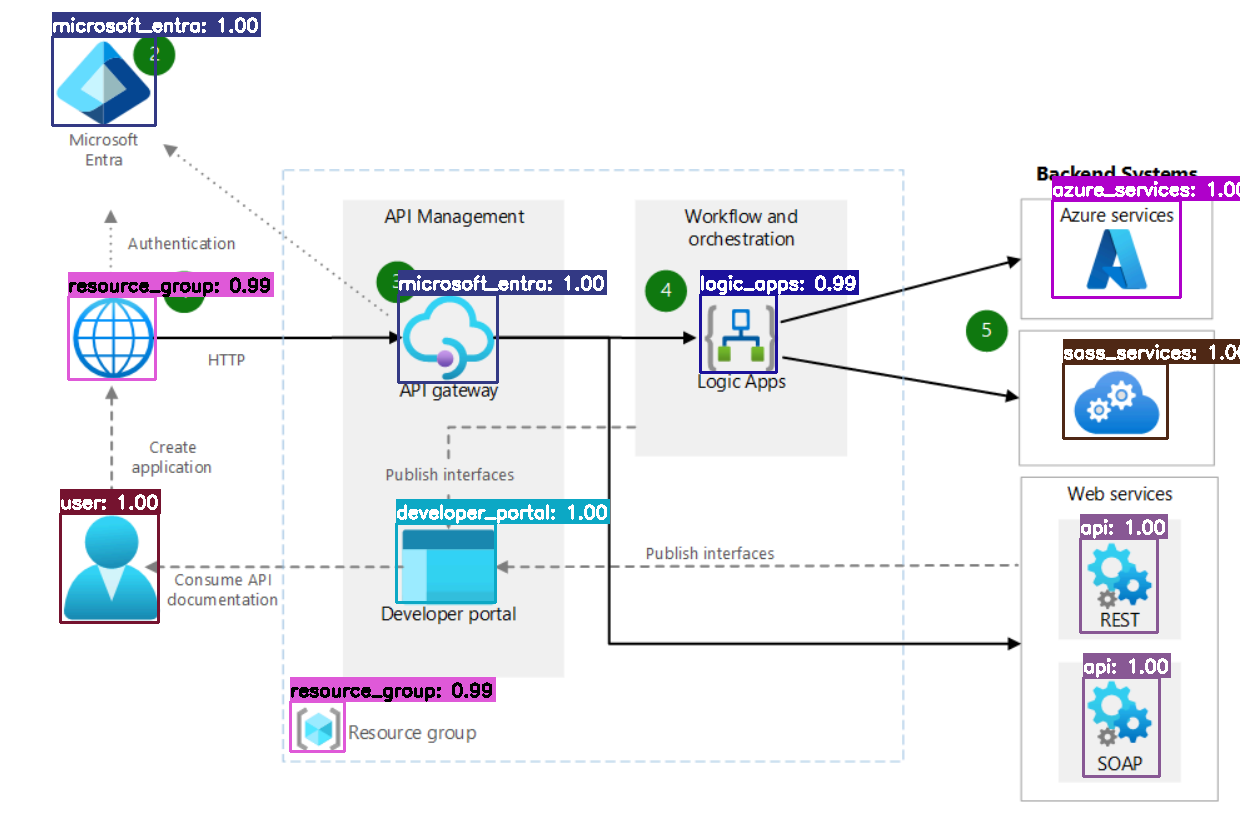

In [ ]:
import json

def read_json_prediction(filepath: str) -> dict[str, Any]:
    """
    Read a JSON prediction file and return its contents as a dictionary.
    """
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)

def get_class_names(json_data: dict[str, Any]) -> set[str]:
    """
    Extract the set of class names from the predictions in the JSON data.
    """
    return set([prediction["displayName"] for prediction in json_data["predictions"]])

data_az = read_json_prediction("/content/drive/MyDrive/hacka/output/202506221544/prediction.json")
data_aws = read_json_prediction("/content/drive/MyDrive/hacka/output/202506221539/prediction.json")
class_names_az = get_class_names(data_az)
class_names_aws = get_class_names(data_aws)